# Galaxy distribution

This example simulates a matter-only light cone up to redshift 1 and samples galaxies from a uniform distribution in redshift.
The results are shown in a pseudo-3D plot.

## Setup

Set up a galaxy-positions-only GLASS simulation. The setup for angular matter power spectra matches the definition from the [Matter shell definition](shells.ipynb) example.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 1.0, dx=200.0)

# linear radial window functions
shells = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, shells)

## Matter

In [ ]:
# set up lognormal matter fields for simulation
fields = glass.lognormal_fields(shells)

# apply discretisation to the full set of spectra:
# - HEALPix pixel window function (`nside=nside`)
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.solve_gaussian_spectra(fields, cls)

# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

## Galaxies

In [ ]:
# constant galaxy density distribution
z = np.linspace(0.0, 1.0, 100)
dndz = np.full_like(z, 0.01)

# distribute the dN/dz over the linear window functions
ngal = glass.partition(z, dndz, shells)

## Simulation

The goal of this example is to make a 3D cube of the sampled galaxy numbers.
A redshift cube is initialised with zero counts, and the simulation is run.
For every shell in the light cone, the galaxies are counted in the cube.

In [ ]:
# make a cube for galaxy number in redshift
zcub = np.linspace(-zb[-1], zb[-1], 21)
cube = np.zeros((zcub.size - 1,) * 3)

# simulate and add galaxies in each matter shell to cube
for i, delta_i in enumerate(matter):
    # simulate positions from matter density
    for gal_lon, gal_lat, gal_count in glass.positions_from_delta(
        ngal[i],
        delta_i,
        rng=rng,
    ):
        # sample redshifts uniformly in shell
        gal_z = glass.redshifts(gal_count, shells[i], rng=rng)

        # add counts to cube
        z1 = gal_z * np.cos(np.deg2rad(gal_lon)) * np.cos(np.deg2rad(gal_lat))
        z2 = gal_z * np.sin(np.deg2rad(gal_lon)) * np.cos(np.deg2rad(gal_lat))
        z3 = gal_z * np.sin(np.deg2rad(gal_lat))
        indices, count = np.unique(
            np.searchsorted(zcub[1:], [z1, z2, z3]),
            axis=1,
            return_counts=True,
        )
        cube[*indices] += count

## Visualisation

Lastly, make a pseudo-3D plot by stacking a number of density slices on top of each other.

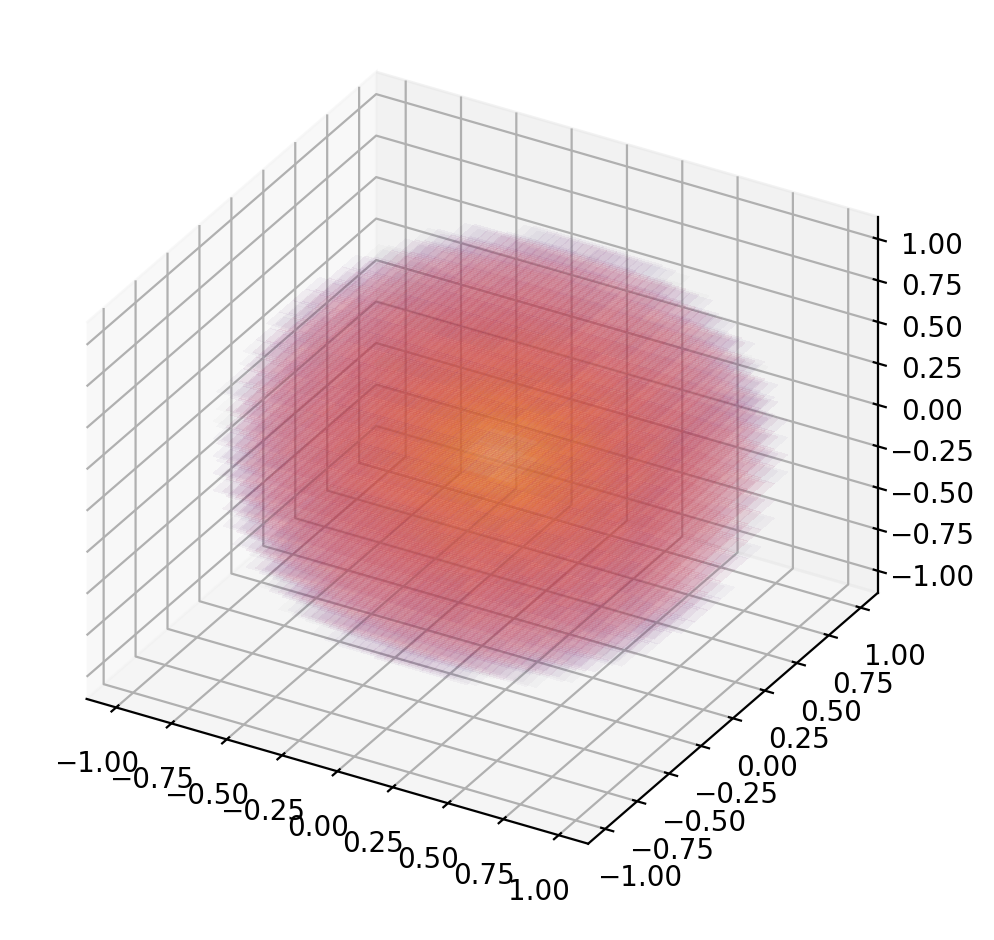

In [ ]:
# positions of grid cells of the cube
z = (zcub[:-1] + zcub[1:]) / 2
z1, z2, z3 = np.meshgrid(z, z, z)

# plot the galaxy distribution in pseudo-3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
norm = LogNorm(vmin=np.min(cube[cube > 0]), vmax=np.max(cube), clip=True)
for i in range(len(zcub) - 1):
    v = norm(cube[..., i])
    c = plt.cm.inferno(v)
    c[..., -1] = 0.2 * v
    ax.plot_surface(
        z1[..., i],
        z2[..., i],
        z3[..., i],
        rstride=1,
        cstride=1,
        facecolors=c,
        linewidth=0,
        shade=False,
        antialiased=False,
    )
fig.tight_layout()
plt.show()